In [ ]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, ConcatDataset, Dataset, TensorDataset
import torchvision.transforms as transforms
from tqdm import tqdm
from collections import Counter, defaultdict
from random import sample
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch import Tensor
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [3]:
data_flag = 'dermamnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

BATCH_SIZE = 128

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=64)
valid_dataset = DataClass(split='val', transform=data_transform, download=download, size=64)
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=64)

# sampler
targets = train_dataset.labels.squeeze()
class_sample_count = np.array([np.sum(targets == t) for t in np.unique(targets)])
weights = 1. / class_sample_count
samples_weights = weights[targets]
sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=8, sampler=sampler)
val_loader = DataLoader(dataset=valid_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=8)

Using downloaded and verified file: /home/tomek/.medmnist/dermamnist_64.npz
Using downloaded and verified file: /home/tomek/.medmnist/dermamnist_64.npz
Using downloaded and verified file: /home/tomek/.medmnist/dermamnist_64.npz


In [5]:
Counter(label[0] for _, label in train_dataset)

Counter({np.int64(0): 228,
         np.int64(5): 4693,
         np.int64(4): 779,
         np.int64(2): 769,
         np.int64(1): 359,
         np.int64(6): 99,
         np.int64(3): 80})

Klasy są niezbalansowane coś trzeba zrobić przy klasyfikatorze

In [6]:
label_to_images = defaultdict(list)

for img, label in test_dataset:
    class_idx = label[0]
    label_to_images[class_idx].append(img)

In [7]:
class MedModel(nn.Module):
    def __init__(self, num_labels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Get ResNet50 model with ImageNet weights
        self.model = models.resnet50(weights='IMAGENET1K_V2')
        # freeze convolution parameters
        for param in self.model.parameters():
            param.requires_grad = False
        num_ftrs = self.model.fc.in_features
        # Fully connected layer with num_labels classes
        self.model.fc = nn.Linear(num_ftrs, num_labels)

    def forward(self, x):
        return self.model(x)

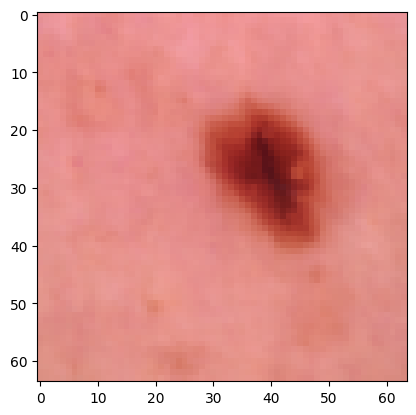

In [8]:
def denormalize(tensor):
    return (tensor+1)/2

def plot_decoded(tensor, get_tensor=False):
    img = denormalize(tensor.detach())
    if get_tensor:
        return img
    # print(img)
    plt.imshow(img.permute(1, 2, 0).numpy())

plot_decoded(valid_dataset[0][0])

In [9]:
def compute_class_weights(train_loader, num_classes):
    class_counts = np.zeros(num_classes)
    
    for _, labels in train_loader:
        for label in labels:
            class_counts[label] += 1
            
    total_samples = len(train_loader.dataset)
    class_weights = total_samples / (num_classes * class_counts)
    
    return torch.tensor(class_weights, dtype=torch.float).to(device)

In [10]:
def accuracy(model, loader, loader_type):
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(1)
            outputs = model(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.cpu()).sum().item()

    print(f'Accuracy of the network on the {total} {loader_type} images: {100 * correct / total:.2f} %')
    return 100 * correct / total

In [11]:
def accuracy_sepearate(model, loader):
    model.eval()

    correct = defaultdict(int)
    total = defaultdict(int)
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.squeeze(1)
            outputs = model(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            for label, pred in zip(labels, predicted):
                label = label.item()
                total[label] += 1
                correct[label] += pred.item() == label
    return [round(100*c/t,2) for c, t in zip(correct.values(), total.values())]

In [12]:
# torch.save(model, 'real_trained_classifier_sampler.pth')
# classifier_real = torch.load('real_trained_classifier_sampler.pth', weights_only=False).to(device)

In [13]:
latent_dim = 100
embedding_dim = 100

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_conditioned_generator = nn.Sequential(
            nn.Embedding(n_classes, embedding_dim),
            nn.Linear(embedding_dim, 16)
        )

        self.latent = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.model = nn.Sequential(
            # input: (B, 513, 4, 4)
            nn.ConvTranspose2d(513, 512, 4, 2, 1, bias=False),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256, momentum=0.1, eps=0.8),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128, momentum=0.1, eps=0.8),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64, momentum=0.1, eps=0.8),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)

        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512, 4, 4)

        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        return image

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
         
     
        self.label_condition_disc = \
        nn.Sequential(
            nn.Embedding(n_classes, embedding_dim),
            nn.Linear(embedding_dim, 3*64*64)
        )
              
        self.model = \
        nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),

            nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
            nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),

            nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
            nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
            nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            # nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
 
    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 64, 64)
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        return self.model(concat)

In [16]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
binary_cross_entropy = torch.nn.BCELoss()

def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    #print(gen_loss)
    return gen_loss

def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    #print(total_loss)
    return disc_loss

In [18]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

In [19]:
# num_epochs = 100
# for epoch in range(1, num_epochs+1): 
 
#     D_loss_list, G_loss_list = [], []
    
#     for i, (real_images, labels) in enumerate(tqdm(train_loader)):
#         optimizer_D.zero_grad()
#         real_images = real_images.to(device)
#         labels = labels.to(device)
#         labels = labels.unsqueeze(1).long()
 
       
#         real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
#         fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))
       
#         D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
#         # print(discriminator(real_images))
#         #D_real_loss.backward()
     
#         noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
#         noise_vector = noise_vector.to(device)
         
        
#         generated_image = generator((noise_vector, labels))
#         output = discriminator((generated_image.detach(), labels))
#         D_fake_loss = discriminator_loss(output,  fake_target)
 
     
#         # train with fake
#         #D_fake_loss.backward()
       
#         D_total_loss = (D_real_loss + D_fake_loss) / 2
#         D_loss_list.append(D_total_loss)
       
#         D_total_loss.backward()
#         optimizer_D.step()
 
#         # Train generator with real labels
#         optimizer_G.zero_grad()
#         G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
#         G_loss_list.append(G_loss)
 
#         G_loss.backward()
#         optimizer_G.step()

#     print(
#         "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
#         % (epoch+1, num_epochs, i+1, len(train_loader), D_total_loss.item(), G_loss.item())
#     )

In [20]:
# torch.save(generator, 'sec_gen1.pth')
# torch.save(discriminator, 'sec_dis1.pth')

generator = torch.load('sec_gen.pth')
discriminator = torch.load('sec_dis')

/tmp/ipykernel_15754/2606268491.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator = torch.load('sec_gen.pth')
/tmp/ipykernel_15754/2606268491.py:5: FutureWarning

In [21]:
def generate_images(samples=1, only_class=-1):
    generator.eval()
    with torch.no_grad():
        images = []
        for _ in range(samples):
            for label in range(n_classes):
                noise_vector = torch.randn(1, latent_dim, device=device)
                label_tensor = torch.tensor([[label if only_class==-1 else only_class]], dtype=torch.long, device=device)

                prediction = generator([noise_vector, label_tensor])
                images.append([prediction, label_tensor])

    return images

In [22]:
import matplotlib.pyplot as plt
import torch

def show_images(images, n, title):
    fig, axes = plt.subplots(1, 7, figsize=(20, 3))

    for idx, img in enumerate(images):
        img_normalized = denormalize(img)
        
        ax = axes[idx]
        ax.imshow(img_normalized.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        ax.axis('off')

    plt.suptitle(f"{title} images for class {n}: {test_dataset.info['label'][str(n)]}")
    
    plt.show()

In [23]:
def check_class(n):
    # generated
    generated= [img for img, _ in generate_images(only_class=n)]
    generated = torch.cat(generated, dim=0)

    # real
    real = sample(label_to_images[n], 7)

    show_images(generated, n, 'generated')
    show_images(real, n, 'real')

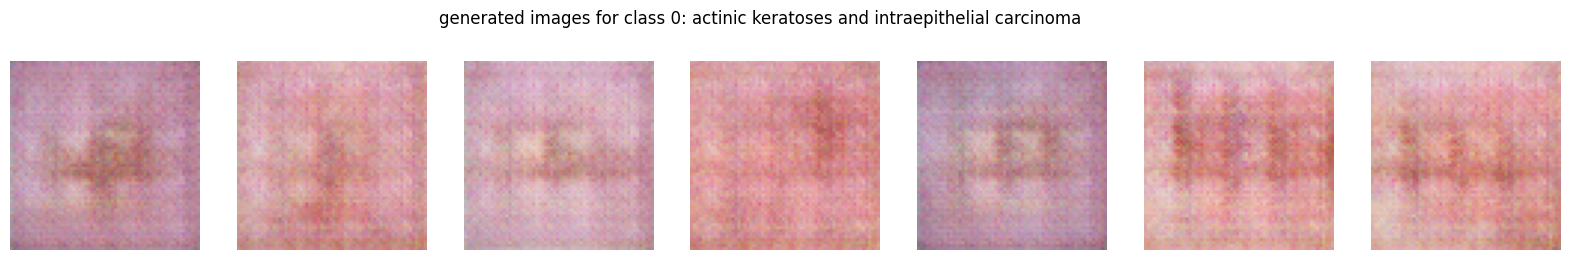

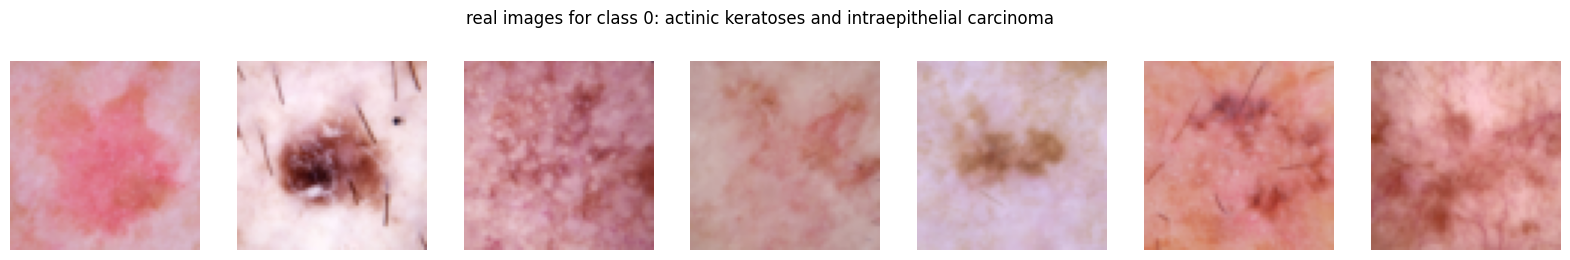

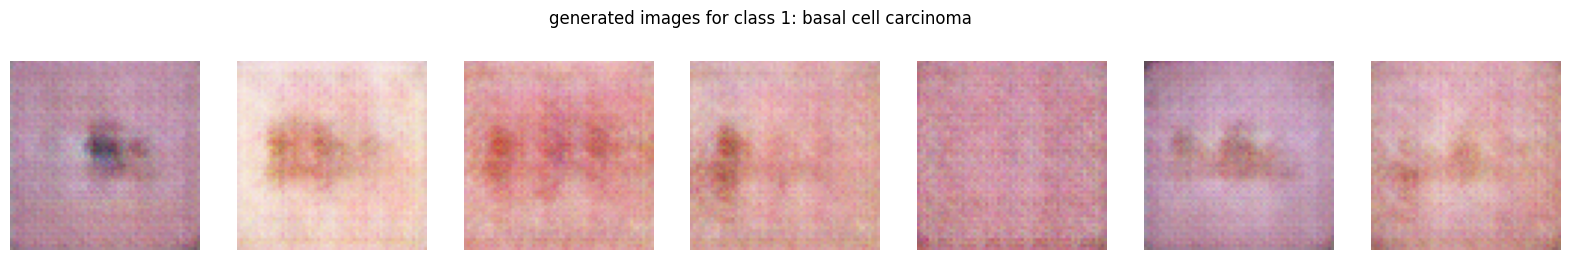

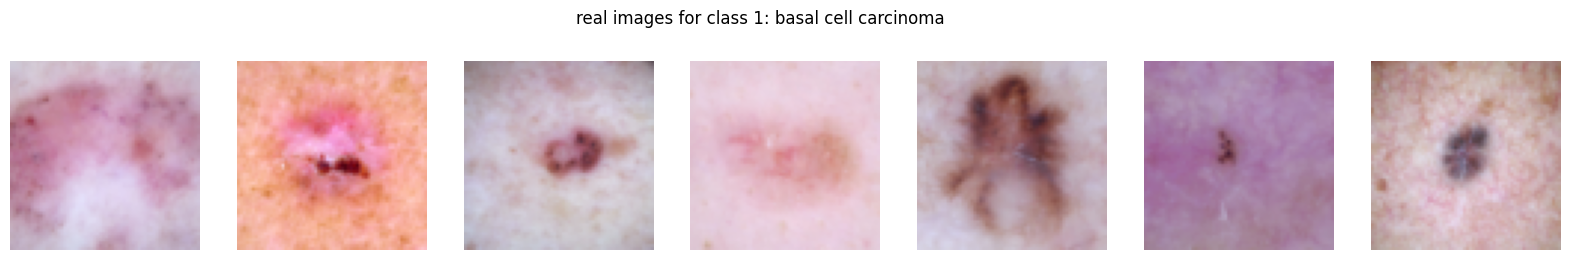

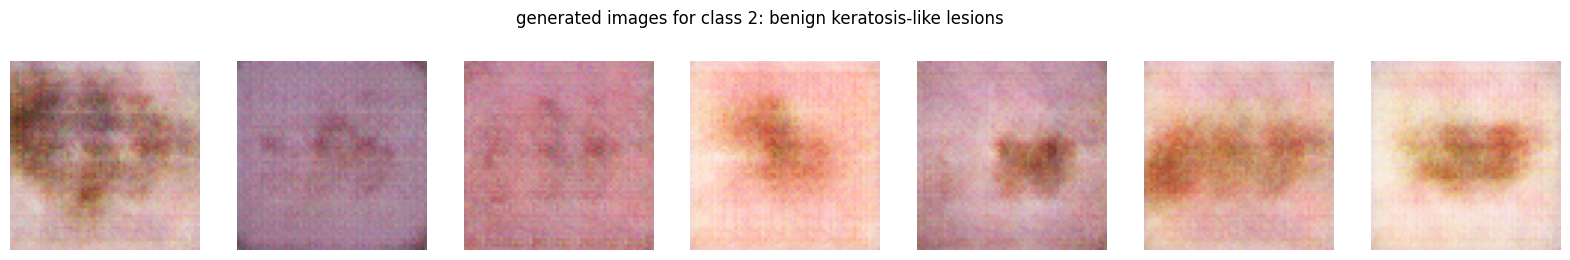

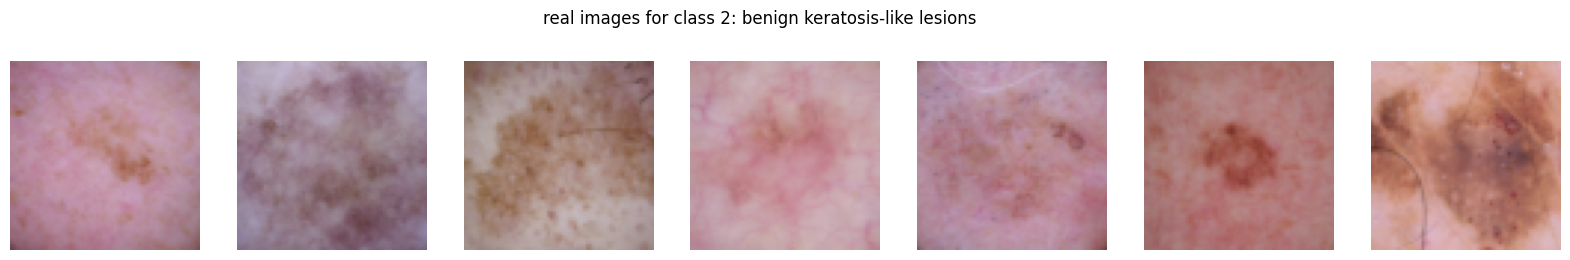

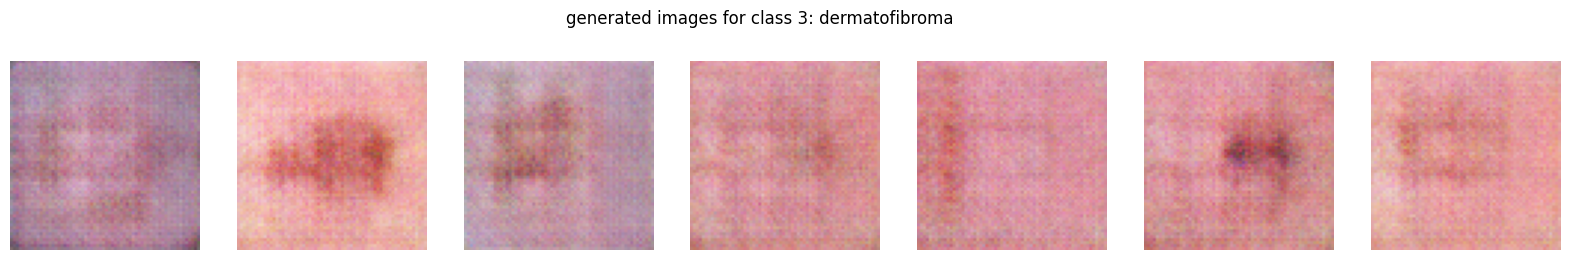

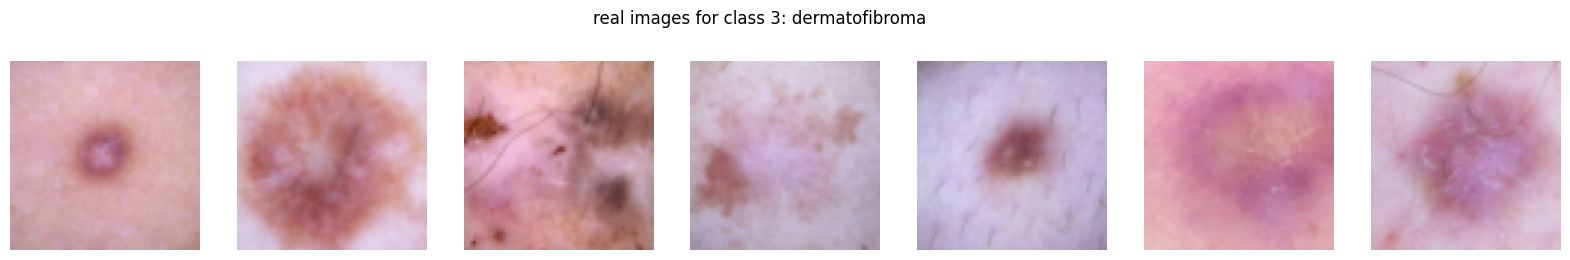

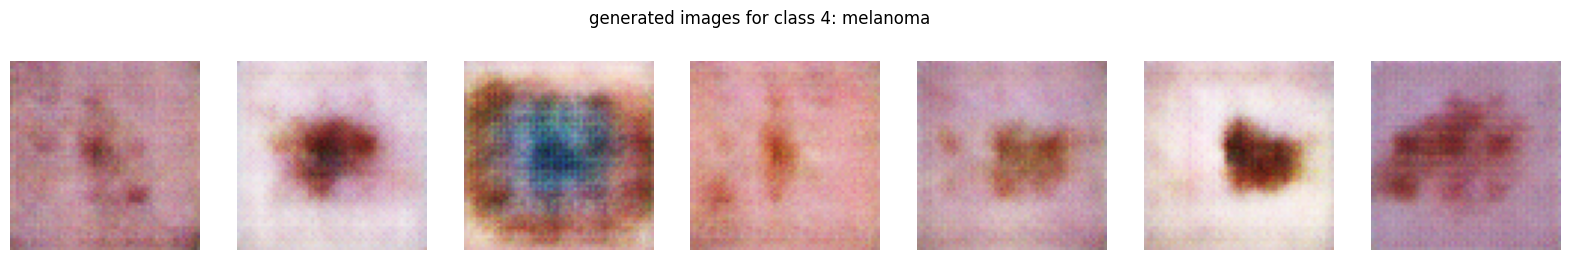

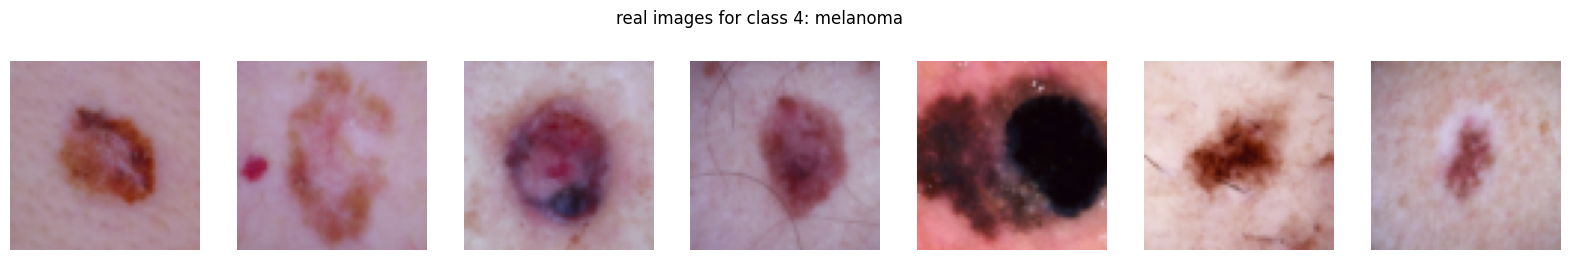

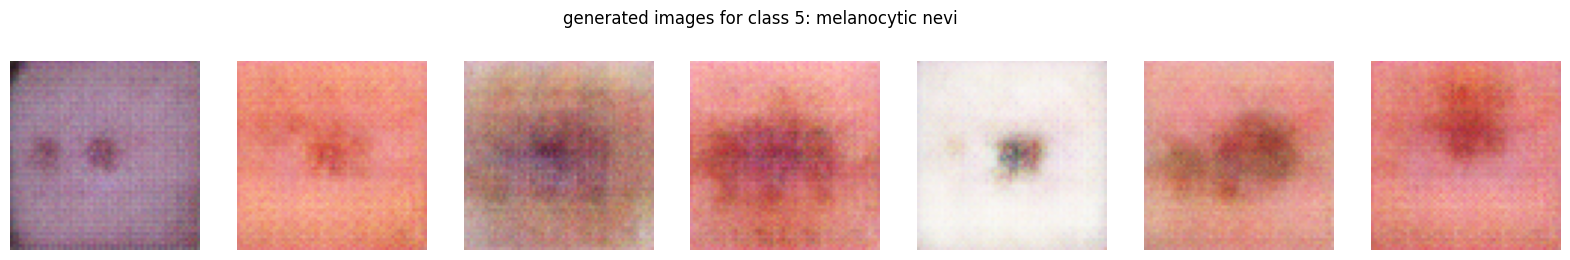

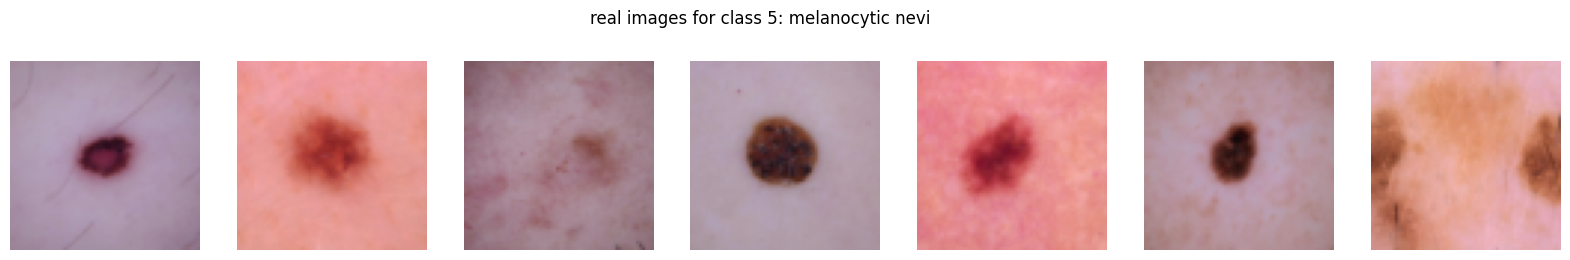

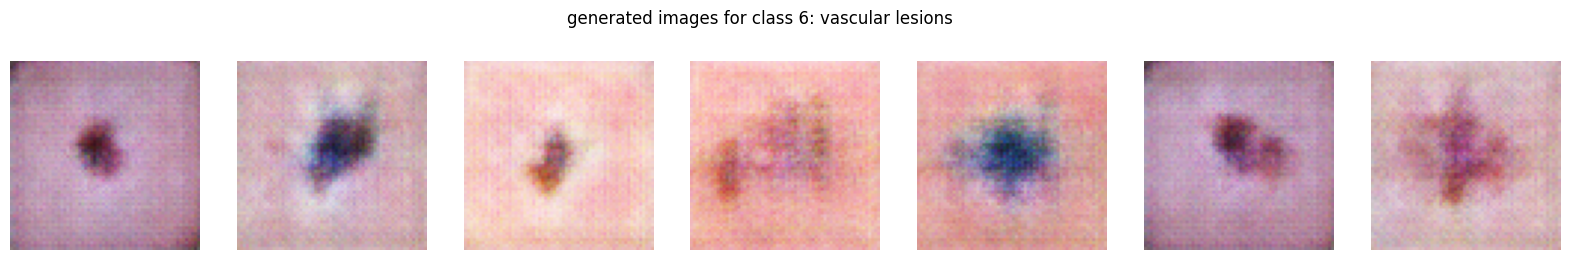

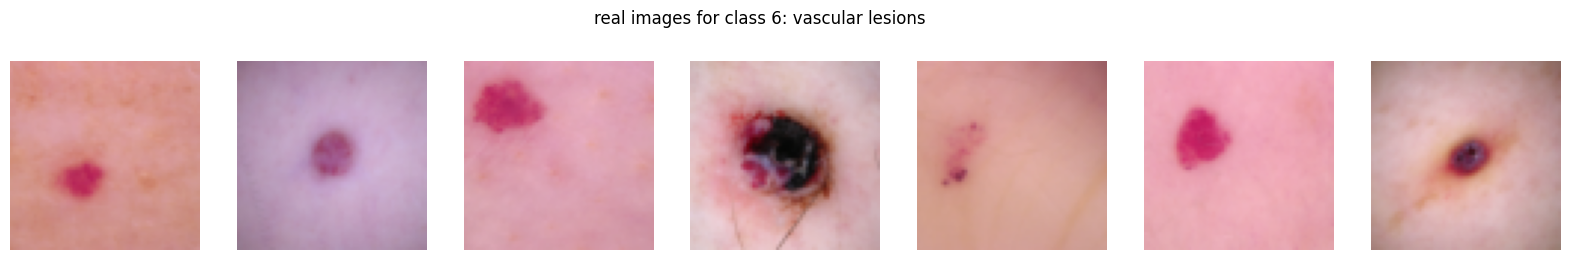

In [24]:
for i in range(7):
    check_class(i)

### Wyniki dla poprzedniego

In [25]:
# results = []

# for i in range(7):
#     results.append(accuracy(generate_images(20, i), f"class {i}"))

# print("Mean accuracy: ", round(sum(results)/7, 2), "%")

### Wyniki dla nowego

In [26]:
# results = []

# for i in range(7):
#     results.append(accuracy(generate_images(20, i), f"class {i}"))

# print("Mean accuracy: ", round(sum(results)/7, 2), "%")

In [27]:
# print(accuracy_sepearate(test_loader))
# accuracy(test_loader, 'real')

# Real model

In [28]:
model_on_real = MedModel(n_classes)
model_on_real = model_on_real.to(device)

criterion = nn.CrossEntropyLoss(weight=compute_class_weights(train_loader, n_classes))
optimizer = optim.Adam(model_on_real.parameters(), lr=0.0005)

num_epochs = 20

for epoch in range(num_epochs):
    model_on_real.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1)

        optimizer.zero_grad()

        outputs = model_on_real(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[%d/{num_epochs}] loss: %.3f' %
          (epoch+1 ,  running_loss / len(train_dataset)))
    # accuracy(model_on_real, train_loader, 'train')
    # accuracy(model_on_real, val_loader, 'valid')
    running_loss = 0.0

print('Finished Training')

100%|██████████| 55/55 [00:08<00:00,  6.47it/s]


[1/20] loss: 0.012


100%|██████████| 55/55 [00:08<00:00,  6.51it/s]


[2/20] loss: 0.010


100%|██████████| 55/55 [00:08<00:00,  6.50it/s]


[3/20] loss: 0.008


100%|██████████| 55/55 [00:08<00:00,  6.50it/s]


[4/20] loss: 0.007


100%|██████████| 55/55 [00:08<00:00,  6.48it/s]


[5/20] loss: 0.007


100%|██████████| 55/55 [00:08<00:00,  6.50it/s]


[6/20] loss: 0.007


100%|██████████| 55/55 [00:08<00:00,  6.48it/s]


[7/20] loss: 0.006


100%|██████████| 55/55 [00:08<00:00,  6.47it/s]


[8/20] loss: 0.006


100%|██████████| 55/55 [00:08<00:00,  6.47it/s]


[9/20] loss: 0.005


100%|██████████| 55/55 [00:08<00:00,  6.46it/s]


[10/20] loss: 0.005


100%|██████████| 55/55 [00:08<00:00,  6.49it/s]


[11/20] loss: 0.005


100%|██████████| 55/55 [00:08<00:00,  6.35it/s]


[12/20] loss: 0.005


100%|██████████| 55/55 [00:08<00:00,  6.46it/s]


[13/20] loss: 0.005


100%|██████████| 55/55 [00:08<00:00,  6.48it/s]


[14/20] loss: 0.005


100%|██████████| 55/55 [00:08<00:00,  6.45it/s]


[15/20] loss: 0.005


100%|██████████| 55/55 [00:08<00:00,  6.37it/s]


[16/20] loss: 0.005


100%|██████████| 55/55 [00:08<00:00,  6.45it/s]


[17/20] loss: 0.004


100%|██████████| 55/55 [00:08<00:00,  6.44it/s]


[18/20] loss: 0.004


100%|██████████| 55/55 [00:08<00:00,  6.48it/s]


[19/20] loss: 0.004


100%|██████████| 55/55 [00:08<00:00,  6.40it/s]

[20/20] loss: 0.004
Finished Training


In [29]:
accuracy(model_on_real, test_loader, 'test')

Accuracy of the network on the 2005 test images: 61.60 %


61.596009975062344

In [30]:
results = []

for i in range(7):
    results.append(accuracy(model_on_real, generate_images(20, i), f"class {i}"))

print("Mean accuracy: ", round(sum(results)/7, 2), "%")

Accuracy of the network on the 140 class 0 images: 3.57 %
Accuracy of the network on the 140 class 1 images: 11.43 %
Accuracy of the network on the 140 class 2 images: 50.00 %
Accuracy of the network on the 140 class 3 images: 19.29 %
Accuracy of the network on the 140 class 4 images: 17.86 %
Accuracy of the network on the 140 class 5 images: 46.43 %
Accuracy of the network on the 140 class 6 images: 22.14 %
Mean accuracy:  24.39 %


In [31]:
torch.save(model_on_real, 'real_trained_classifier.pth')

# Fake model

In [32]:
model_on_faked = MedModel(n_classes)
model_on_faked = model_on_faked.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_on_faked.parameters(), lr=0.0005)

fake_data = generate_images(400)

fake_loader = DataLoader(dataset=fake_data, batch_size=2*BATCH_SIZE, shuffle=True)

num_epochs = 25

for epoch in range(num_epochs):
    model_on_faked.train()
    running_loss = 0.0
    for inputs, labels in tqdm(fake_loader):
        inputs, labels
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1).squeeze(1)
        inputs = inputs.squeeze(1)
        optimizer.zero_grad()

        outputs = model_on_faked(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[%d/{num_epochs}] loss: %.3f' %
          (epoch+1 ,  running_loss / len(train_dataset)))
    # accuracy(model_on_faked, train_loader, 'train')
    # accuracy(model_on_faked, val_loader, 'valid')
    running_loss = 0.0

print('Finished Training')

100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[1/25] loss: 0.003


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[2/25] loss: 0.003


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[3/25] loss: 0.002


100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


[4/25] loss: 0.002


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[5/25] loss: 0.002


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[6/25] loss: 0.002


100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


[7/25] loss: 0.002


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[8/25] loss: 0.002


100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


[9/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[10/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[11/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[12/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


[13/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[14/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[15/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[16/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[17/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[18/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


[19/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


[20/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[21/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[22/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


[23/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


[24/25] loss: 0.001


100%|██████████| 11/11 [00:02<00:00,  3.72it/s]

[25/25] loss: 0.001
Finished Training


In [33]:
accuracy(model_on_faked, test_loader, 'test')

results = []

for i in range(7):
    results.append(accuracy(model_on_faked, generate_images(20, i), f"class {i}"))

print("Mean accuracy: ", round(sum(results)/7, 2), "%")

Accuracy of the network on the 2005 test images: 25.99 %
Accuracy of the network on the 140 class 0 images: 81.43 %
Accuracy of the network on the 140 class 1 images: 68.57 %
Accuracy of the network on the 140 class 2 images: 77.14 %
Accuracy of the network on the 140 class 3 images: 80.00 %
Accuracy of the network on the 140 class 4 images: 73.57 %
Accuracy of the network on the 140 class 5 images: 75.71 %
Accuracy of the network on the 140 class 6 images: 74.29 %
Mean accuracy:  75.82 %


In [34]:
torch.save(model_on_faked, 'fake_trained_classifier.pth')

# Mixed model

In [ ]:
# aby dopasować że labele mają ten sam typ
class ToTensorWrapper(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        return x, torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.dataset)

In [ ]:
train_dataset_tensor = ToTensorWrapper(train_dataset)

x_fake = torch.stack([x.squeeze(0) for x, y in fake_data]).cpu()
y_fake = torch.stack([y.view(-1) for x, y in fake_data]).cpu()
fake_dataset = TensorDataset(x_fake, y_fake)

mixed_dataset = ConcatDataset([train_dataset_tensor, fake_dataset])
mixed_loader = DataLoader(mixed_dataset, batch_size=2 * BATCH_SIZE, shuffle=True)

In [ ]:
model_on_mixed = MedModel(n_classes)
model_on_mixed = model_on_mixed.to(device)
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=compute_class_weights(mixed_loader, n_classes))
optimizer = optim.Adam(model_on_mixed.parameters(), lr=0.0005)
num_epochs = 20

for epoch in range(num_epochs):
    model_on_mixed.train()
    running_loss = 0.0
    for inputs, labels in tqdm(mixed_loader):
        inputs, labels
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1)

        optimizer.zero_grad()

        outputs = model_on_mixed(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[%d/{num_epochs}] loss: %.3f' %
          (epoch+1 ,  running_loss / len(train_dataset)))
    # accuracy(model_on_mixed, train_loader, 'train')
    # accuracy(model_on_mixed, val_loader, 'valid')
    running_loss = 0.0

print('Finished Training')

100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


[1/20] loss: 0.008


100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


[2/20] loss: 0.006


100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


[3/20] loss: 0.006


100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


[4/20] loss: 0.005


100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


[5/20] loss: 0.005


100%|██████████| 39/39 [00:11<00:00,  3.39it/s]


[6/20] loss: 0.005


100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


[7/20] loss: 0.005


100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


[8/20] loss: 0.004


100%|██████████| 39/39 [00:11<00:00,  3.29it/s]


[9/20] loss: 0.004


100%|██████████| 39/39 [00:11<00:00,  3.31it/s]


[10/20] loss: 0.004


100%|██████████| 39/39 [00:11<00:00,  3.35it/s]


[11/20] loss: 0.004


100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


[12/20] loss: 0.004


100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


[13/20] loss: 0.004


100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


[14/20] loss: 0.004


100%|██████████| 39/39 [00:11<00:00,  3.35it/s]


[15/20] loss: 0.004


100%|██████████| 39/39 [00:11<00:00,  3.29it/s]


[16/20] loss: 0.004


100%|██████████| 39/39 [00:11<00:00,  3.32it/s]


[17/20] loss: 0.004


100%|██████████| 39/39 [00:11<00:00,  3.33it/s]


[18/20] loss: 0.004


100%|██████████| 39/39 [00:11<00:00,  3.32it/s]


[19/20] loss: 0.003


100%|██████████| 39/39 [00:11<00:00,  3.35it/s]

[20/20] loss: 0.003
Finished Training


In [102]:
accuracy(model_on_mixed, test_loader, 'test')

results = []

for i in range(7):
    results.append(accuracy(model_on_mixed, generate_images(20, i), f"class {i}"))

print("Mean accuracy: ", round(sum(results)/7, 2), "%")

Accuracy of the network on the 2005 test images: 70.57 %
Accuracy of the network on the 140 class 0 images: 85.00 %
Accuracy of the network on the 140 class 1 images: 70.00 %
Accuracy of the network on the 140 class 2 images: 71.43 %
Accuracy of the network on the 140 class 3 images: 83.57 %
Accuracy of the network on the 140 class 4 images: 65.71 %
Accuracy of the network on the 140 class 5 images: 74.29 %
Accuracy of the network on the 140 class 6 images: 82.86 %
Mean accuracy:  76.12 %


In [103]:
torch.save(model_on_mixed, 'mixed_trained_classifier.pth')